# One Node Scenarios

## Outbreak in Naive Population

In [12]:
from pathlib import Path

import numpy as np

from idmlaser.numpynumba import DemographicsByYear
from idmlaser.models import NumbaSpatialSEIR
from idmlaser.utils import GrabBag

metaparams = GrabBag({
    "ticks": 365,
    "nodes": 1,
    "seed": 20240625,
    "output": Path.cwd() / "outputs",
})

modelparams = GrabBag({
    "exp_mean": np.float32(7.0),
    "exp_std": np.float32(1.0),
    "inf_mean": np.float32(7.0),
    "inf_std": np.float32(1.0),
    "r_naught": np.float32(14.0),
    "seasonality_factor": np.float32(0.125),
    "seasonality_offset": np.float32(182),
})

params = GrabBag(metaparams, modelparams)

model = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=1, nnodes=1)
CAPACITY = 1_000_000
demographics.initialize(initial_population = CAPACITY)

max_capacity = CAPACITY
INFECTIONS = 10
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0,:] = [CAPACITY - INFECTIONS, 0, INFECTIONS, 0] # S, E, I, R
network = np.zeros((1, 1), dtype=np.float32)    # 1x1 network
model.initialize(max_capacity, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 365, 'nodes': 1, 'seed': 20240625, 'output': PosixPath('/workspaces/laser/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Initializing model with 1 nodes: (initial population: 1,000,000 maximum capacity: 1,000,000)


In [13]:
model.run(params.ticks)

100%|██████████| 365/365 [00:02<00:00, 139.72it/s]

elapsed time: 0:00:02.615015


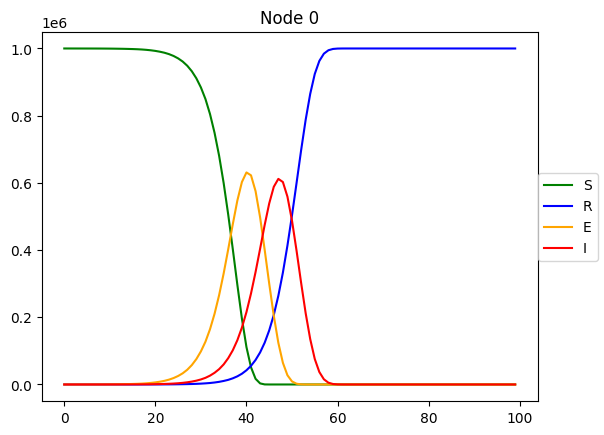

In [21]:
import matplotlib.pyplot as plt

def plot_channels(report, node=0, ticks=-1, twin=False):
    S = report[:ticks, 0, node]   # first 100 ticks, channel 0, node 0
    E = report[:ticks, 1, node]
    I = report[:ticks, 2, node]
    R = report[:ticks, 3, node]

    fig, ax1 = plt.subplots()
    plt.plot(S, label='S', color="green")
    plt.plot(R, label='R', color="blue")
    if twin:
        ax2 = ax1.twinx()
    # ax2.set_yscale("log")
    plt.plot(E, label='E', color="orange")
    plt.plot(I, label='I', color="red")
    plt.title(f"Node {node}")
    fig.legend(loc="center right")
    plt.show()

plot_channels(model.report, node=0, ticks=100)

## Periodicity

In [41]:
YEARS = 20
params += ({"ticks": 365*YEARS})   # override the ticks parameter
params += ({"seed": 2718281828})

model2 = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=YEARS, nnodes=1)
CAPACITY = 2_000_000
demographics.initialize(initial_population = CAPACITY, cbr=18.0)

max_capacity = demographics.population[0, 0] + demographics.births[:, 0].sum()
SUSCEPTIBLE = int(CAPACITY / params.r_naught)
EXPOSED = 0
INFECTIONS = 50
RECOVERED = CAPACITY - (SUSCEPTIBLE + EXPOSED + INFECTIONS)
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0,:] = [SUSCEPTIBLE, EXPOSED, INFECTIONS, RECOVERED]
network = np.zeros((1, 1), dtype=np.float32)    # 1x1 network
model2.initialize(max_capacity, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 7300, 'nodes': 1, 'seed': 2718281828, 'output': PosixPath('/workspaces/laser/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Initializing model with 1 nodes: (initial population: 2,000,000 maximum capacity: 2,857,496)


In [42]:
model2.run(params.ticks)

  0%|          | 0/7300 [00:00<?, ?it/s]

100%|██████████| 7300/7300 [02:12<00:00, 55.14it/s]

elapsed time: 0:02:12.392671


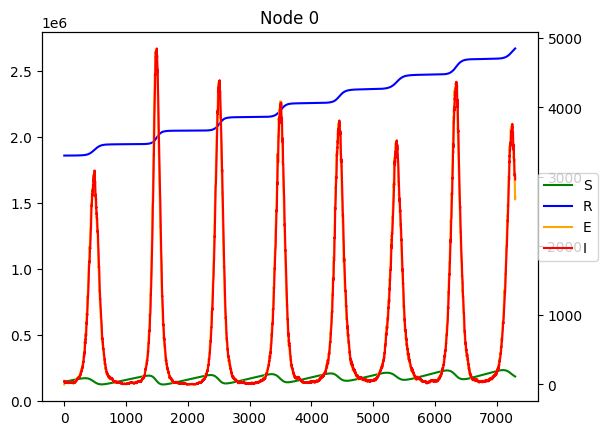

In [43]:
plot_channels(model2.report, node=0, ticks=params.ticks,twin=True)